## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
import string

In [2]:
# reading the Treebank universal-tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# top 10 sentences with each word tagged with POS tags in the form of tuples
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into training (95%) and test (5%)
train_set, test_set = train_test_split(nltk_data,test_size=0.05, random_state = 2345)

print('Number of sentences in training set: ',len(train_set))
print('Number of sentences in test set: ', len(test_set))

Number of sentences in training set:  3718
Number of sentences in test set:  196


In [5]:
# listing of tuples with words and corresponding POS tag accross sentences in the training set
train_tagged_words = [tup for sent in train_set for tup in sent]
# list of words from (word, POS) tuple from the list of tuples in the training set
tokens = [pair[0] for pair in train_tagged_words]
# vocabulary, V the set of distinct words
V = set(tokens)
# tag-set i.e., set of distinct tags
T = set([pair[1] for pair in train_tagged_words])

print('Size of tag-set or number of tags: ',len(T))
print('The tags in the universal tag-set....')
print(T)

Size of tag-set or number of tags:  12
The tags in the universal tag-set....
{'ADP', 'VERB', 'NUM', 'PRON', 'ADJ', '.', 'CONJ', 'X', 'ADV', 'PRT', 'DET', 'NOUN'}


### Build the vanilla Viterbi based POS tagger

In [6]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [7]:
# computing word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [8]:
# computing tag given previous tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [9]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1 (previous tag)
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [10]:
# converting the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [11]:
tags_df

,ADP,VERB,NUM,PRON,ADJ,.,CONJ,X,ADV,PRT,DET,NOUN
ADP,0.016495,0.008462,0.063196,0.068445,0.104542,0.039739,0.000857,0.034597,0.013496,0.001392,0.324336,0.324443
VERB,0.092022,0.167979,0.023162,0.035639,0.065507,0.035093,0.005537,0.217968,0.081260,0.031506,0.134290,0.110037
NUM,0.033481,0.018370,0.184000,0.001185,0.032296,0.114667,0.013630,0.210963,0.002963,0.026370,0.003852,0.358222
PRON,0.022342,0.486903,0.007319,0.007704,0.072034,0.042373,0.005393,0.092450,0.032357,0.011941,0.010015,0.209168
ADJ,0.078756,0.011747,0.020516,0.000662,0.065354,0.067174,0.016545,0.020185,0.004302,0.010754,0.005129,0.698875
.,0.090051,0.089332,0.080884,0.066235,0.044486,0.094095,0.057877,0.027501,0.052665,0.002427,0.172913,0.221443
CONJ,0.052485,0.159313,0.042267,0.057594,0.115653,0.034371,0.000464,0.007896,0.054807,0.005109,0.119833,0.350209
X,0.143681,0.204709,0.002883,0.055903,0.017620,0.163864,0.010732,0.073522,0.024828,0.185007,0.054942,0.062310
ADV,0.117981,0.345588,0.031417,0.015040,0.129345,0.138369,0.007019,0.023061,0.079211,0.014037,0.067848,0.031083
PRT,0.021025,0.399474,0.057490,0.018397,0.086399,0.043035,0.002300,0.013141,0.010184,0.001971,0.100197,0.246386


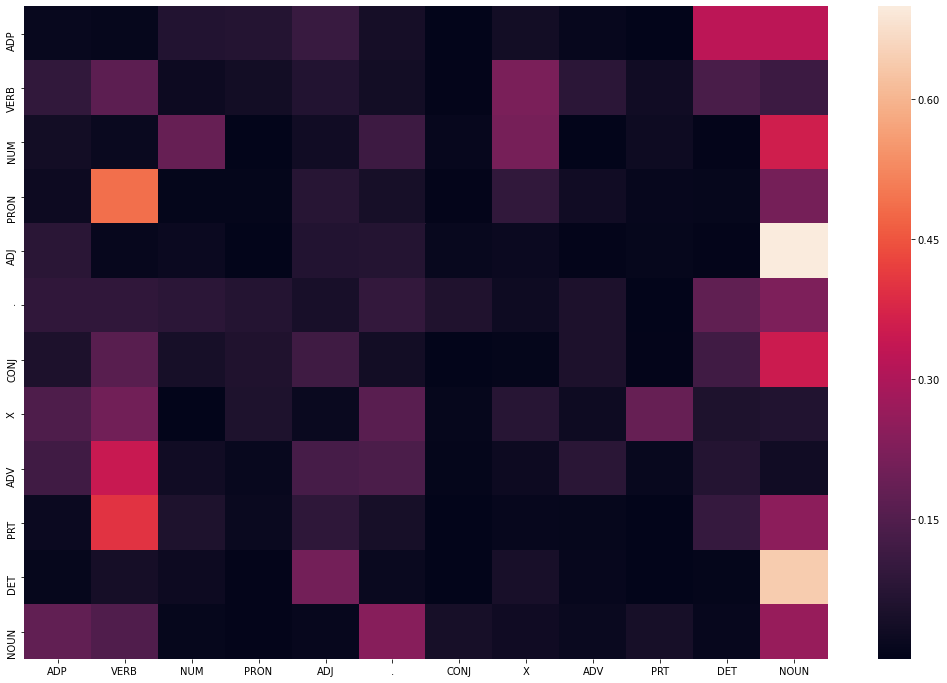

In [12]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

In [13]:
# Baseline Viterbi
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialising list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [14]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [15]:
# tagging the test sentences with Baseline Viterbi
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  946.6246590614319


### Solve the problem of unknown words

#### Technique 1: Rule-based Viterbi
##### 1. If word, in training corpus, state probability = emission probability * transition probability
##### 2. If word, not in training corpus and is 'ing' ending, then it is tagged as VERB (morphological cue)
##### 3. If word, not in training corpus and nor 'ing' ending, then it is tagged with the most occuring POS tag in the training corpus

In [16]:
# Rule-based Viterbi Heuristic
def modViterbi1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    most_occuring_tag = list(dict(Counter([pair[1] for pair in train_bag])).keys())[0]
    
    for key, word in enumerate(words):
        if word in [pair[0] for pair in train_bag]:
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            if re.search("([a-zA-Z]+)ing", word):
                state.append('VERB')
            else:
                state.append(most_occuring_tag)
    return list(zip(words, state))

In [17]:
# tagging the test sentences with Rule-based Viterbi
start = time.time()
tagged_seq_mod1 = modViterbi1(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  859.363618850708


#### Technique 2: Probabilistic Viterbi
##### 1. If word, in training corpus, state probability = emission probability * transition probability
##### 2. If word, not in training corpus, state probability = transition probability

In [18]:
# Probabilistic Viterbi Heuristic
def modViterbi2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            if word in [pair[0] for pair in train_bag]:

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p
            else:
                state_probability = transition_p
                
            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# tagging the test sentences with Probabilistic Viterbi
start = time.time()
tagged_seq_mod2 = modViterbi2(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  1186.6616406440735


#### Evaluating tagging accuracy

In [20]:
# accuracy of baseline Viterbi
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_baselineViterbi = len(check)/len(tagged_seq)

In [21]:
# accuracy of rule-based Viterbi
check = [i for i, j in zip(tagged_seq_mod1, test_run_base) if i == j]
accuracy_rulebasedViterbi = len(check)/len(tagged_seq_mod1)

In [22]:
# accuracy of probabilistic Viterbi
check = [i for i, j in zip(tagged_seq_mod2, test_run_base) if i == j]
accuracy_probabilisticViterbi = len(check)/len(tagged_seq_mod2)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [23]:
print('Test Accuracy by baseline Viterbi: ', accuracy_baselineViterbi)

Test Accuracy by baseline Viterbi:  0.908661119515885


In [24]:
print('Test Accuracy by rule-based Viterbi Modification: ', accuracy_rulebasedViterbi)

Test Accuracy by rule-based Viterbi Modification:  0.9421331316187594


In [25]:
print('Test Accuracy by probabilistic Viterbi Modification: ', accuracy_probabilisticViterbi)

Test Accuracy by probabilistic Viterbi Modification:  0.9406202723146747


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Incorrect tagged cases of Baseline Viterbi

In [26]:
incorrect_tagged_cases_baseline = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_baseline

[[("''", '.'), (('Bribe', 'ADP'), ('Bribe', 'NOUN'))],
 [('by', 'ADP'), (('bribe', 'ADP'), ('bribe', 'NOUN'))],
 [(',', '.'), (('Matthew', 'ADP'), ('Matthew', 'NOUN'))],
 [('C.', 'NOUN'), (('Harrison', 'ADP'), ('Harrison', 'NOUN'))],
 [('the', 'DET'), (('path', 'ADP'), ('path', 'NOUN'))],
 [('Wedtech', 'NOUN'), (('traveled', 'ADP'), ('traveled', 'VERB'))],
 [('its', 'PRON'), (('inception', 'ADP'), ('inception', 'NOUN'))],
 [('small', 'ADJ'), (('manufacturing', 'NOUN'), ('manufacturing', 'VERB'))],
 [('of', 'ADP'), (('full-fledged', 'ADP'), ('full-fledged', 'ADJ'))],
 [('producing', 'VERB'), (('vital', 'ADP'), ('vital', 'ADJ'))],
 [('.', '.'), (('Brisk', 'ADP'), ('Brisk', 'ADJ'))],
 [('pushed', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('solid', 'ADJ'), (('382-37', 'ADP'), ('382-37', 'NUM'))],
 [("'s", 'PRT'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('of', 'ADP'), (('therapies', 'ADP'), ('therapies', 'NOUN'))],
 [('in', 'ADP'), (('abortions', 'ADP'), ('abortions', 'NOUN'))],
 [(',', '.

#### Corrections by Rule-based Viterbi over Incorrect tagged cases of Baseline Viterbi

In [27]:
correct_tagged_cases_rulebasedViterbi = [[test_run_base[i-1],j[1]] for i, j in enumerate(zip(tagged_seq_mod1, test_run_base)) if j[0]==j[1]]
incorrect_tagged_cases_baseline = [[test_run_base[i-1],j[1]] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
corrections_rulebasedViterbi = [x for x in correct_tagged_cases_rulebasedViterbi if x in incorrect_tagged_cases_baseline]
corrections_rulebasedViterbi

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('its', 'PRON'), ('inception', 'NOUN')],
 [('of', 'ADP'), ('therapies', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('or', 'CONJ'), ('retaliating', 'VERB')],
 [('a', 'DET'), ('bargain', 'NOUN')],
 [('the', 'DET'), ('Purepac', 'NOUN')],
 [('Purepac', 'NOUN'), ('label', 'NOUN')],
 [('Donald', 'NOUN'), ('Pardus', 'NOUN')],
 [('.', '.'), ('Centerbank', 'NOUN')],
 [('of', 'ADP'), ('NESB', 'NOUN')],
 [('and', 'CONJ'), ('life-style', 'NOUN')],
 [('numerous', 'ADJ'), ('sub-markets', 'NOUN')],
 [('.', '.'), ('Paris', 'NOUN')],
 [(',', '.'), ('Brussels', 'NOUN')],
 [('and', 'CONJ'), ('Milan', 'NOUN')],
 [('.', '.'), ('Activity', 'NOUN')],
 [('.', '.'), ('Part', 'NOUN')],
 [('of', 'ADP'), ('jitters', 'NOUN')],
 [('.', '.'), ('Attorneys', 'NOUN')],
 [('Johnson', 'N

#### Corrections by Probabilistic Viterbi over Incorrect tagged cases of Baseline Viterbi

In [28]:
correct_tagged_cases_probabilisticViterbi = [[test_run_base[i-1],j[1]] for i, j in enumerate(zip(tagged_seq_mod2, test_run_base)) if j[0]==j[1]]
incorrect_tagged_cases_baseline = [[test_run_base[i-1],j[1]] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
corrections_probabilisticViterbi = [x for x in correct_tagged_cases_probabilisticViterbi if x in incorrect_tagged_cases_baseline]
corrections_probabilisticViterbi

[[("''", '.'), ('Bribe', 'NOUN')],
 [('by', 'ADP'), ('bribe', 'NOUN')],
 [(',', '.'), ('Matthew', 'NOUN')],
 [('C.', 'NOUN'), ('Harrison', 'NOUN')],
 [('the', 'DET'), ('path', 'NOUN')],
 [('of', 'ADP'), ('therapies', 'NOUN')],
 [('in', 'ADP'), ('abortions', 'NOUN')],
 [('*-2', 'X'), ('punishing', 'VERB')],
 [('a', 'DET'), ('bargain', 'NOUN')],
 [('the', 'DET'), ('Purepac', 'NOUN')],
 [('Purepac', 'NOUN'), ('label', 'NOUN')],
 [('Donald', 'NOUN'), ('Pardus', 'NOUN')],
 [('.', '.'), ('Centerbank', 'NOUN')],
 [('of', 'ADP'), ('NESB', 'NOUN')],
 [('and', 'CONJ'), ('life-style', 'NOUN')],
 [('numerous', 'ADJ'), ('sub-markets', 'NOUN')],
 [('.', '.'), ('Paris', 'NOUN')],
 [(',', '.'), ('Brussels', 'NOUN')],
 [('and', 'CONJ'), ('Milan', 'NOUN')],
 [('it', 'PRON'), ('resists', 'VERB')],
 [('.', '.'), ('Activity', 'NOUN')],
 [('.', '.'), ('Part', 'NOUN')],
 [('of', 'ADP'), ('jitters', 'NOUN')],
 [('.', '.'), ('Attorneys', 'NOUN')],
 [('Johnson', 'NOUN'), ('Lowe', 'NOUN')],
 [('a', 'DET'), ('cas

### POS Tagging in Sample Test File 

In [29]:
f = open('Test_sentences.txt', 'r') # reading the Sample test file
list_of_sentences = f.readlines() # reading the lines into a list of lines
for sentence in list_of_sentences:
    sentence = sentence.strip('\n') # getting rid of new line characters
    if len(sentence) > 0: # not taking empty sentences into consideration
        untagged_words = word_tokenize(sentence) # tokenizing each sentence
        print(sentence) # printing the original sentence
        # tagging using Baseline Viterbi
        print('Baseline Viterbi Tagging.....')
        start = time.time()
        tagged_seq = Viterbi(untagged_words)
        print(tagged_seq) # printing the output by baseline Viterbi 
        end = time.time()
        difference = end-start
        print("Time taken in seconds: ", difference)
        print('\n')
        # tagging using Rule-based Viterbi
        print('Rule-based Viterbi Tagging.....')
        start = time.time()
        tagged_seq_mod1 = modViterbi1(untagged_words)
        print(tagged_seq_mod1) # printing the output by rule-based Viterbi
        end = time.time()
        difference = end-start
        print("Time taken in seconds: ", difference)
        print('\n')
        # tagging using Probabilistic Viterbi
        print('Probabilistic Viterbi Tagging.....')
        start = time.time()
        tagged_seq_mod2 = modViterbi2(untagged_words)
        print(tagged_seq_mod2) # printing the output by probabilistic Viterbi
        end = time.time()
        difference = end-start
        print("Time taken in seconds: ", difference)
        print('\n\n')

Android is a mobile operating system developed by Google.
Baseline Viterbi Tagging.....
[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
Time taken in seconds:  1.5311613082885742


Rule-based Viterbi Tagging.....
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Time taken in seconds:  1.2190628051757812


Probabilistic Viterbi Tagging.....
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Time taken in seconds:  1.944798469543457



Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Baseline Viterbi Tagging.....
[('Android', 'ADP'), ('has', '

[('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]
Time taken in seconds:  5.192149639129639



Show me the cheapest round trips from Dallas to Atlanta
Baseline Viterbi Tagging.....
[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'ADP'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]
Time taken in seconds:  1.4552762508392334


Rule-based Viterbi Tagging.....
[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]
Time taken in sec

### 1. Android in the 1st sentence, 1st token wrongly tagged as Adposition by baseline Virerbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 2. Google in the 1st sentence, last token (before .) wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging is as Noun
### 3. OS in the 2nd sentence, 6th token wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 4. smartphones in the 2nd sentence, 9th token wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 5. Twitter in the 3rd sentence, 3rd token wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 6. firehose in the 3rd sentence, last token (before .) wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based Viterbi by tagging it as Noun
### 7. messages in the 4th sentence, 17th token wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 8. tweets in the 4th sntence, last token (before .) wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 9. personality in the 5th sentence, last token (before .) wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun
### 10. FIFA in the 6th sentence, 3rd token wrongly tagged as Adposition by baseline Viterbi, is corrected by rule-based and probabilistic Viterbi by tagging it as Noun